# 4. Compare the peaks where ChIP-seq and CUT&RUN share peaks, but have significantly different total counts

In [50]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table, import_profiles, import_tfmodisco_results
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

plt.rcParams["figure.dpi"] = 130

/tmp/ipykernel_6968/1013105652.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

## Preliminaries

1) Find ChIP-seq peaks that overlap CUT&RUN peaks, and vice versa

2) Load in true total counts arrays

In [2]:
# THE COORDS FOR THE SHAP AND PREDS HDF5s ARE THE  * S A M E *  YES I CHECKED!

# Import the set of all profiles and their coordinates - SAME FOR COUNTS HEAD AS FOR PROFILE HEAD, D U H !!!!
# EXACTLY SAME AS IMPORTING THE ORIGINAL HDF5 FROM PIPELINE_OUTPUTS   YES I CHECKED
true_profs_chip, pred_profs_chip, all_pred_coords_chip = import_profiles('/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_feb7/preds')
true_profs_cut, pred_profs_cut, all_pred_coords_cut = import_profiles('/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_feb7/preds')

# load in shared peaks
chip_peaks_shared_cut = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_chip_with_any_cutnrun_overlap'])
cut_peaks_shared_chip = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/assay_peaks_overlap/CTCF_unique_cutnrun_with_any_chip_overlap'])

# redo peak name in chipseq to get rid of "Peak_" and to reindex name (peak) column to 0-indexed
chip_peaks_shared_cut.name = chip_peaks_shared_cut.name.replace('Peak_','', regex=True).astype(int)
chip_peaks_shared_cut.name -= 1



Importing predictions:   0%|          | 0/72 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/109 [00:00<?, ?it/s]

3. Drop duplicates so each row corresponds to each peak of the peak table (+ issues with chrM and chrY that I need to account for). *also get the indices of the shared peaks*

4. Index true counts to the shared peaks

In [3]:
# create dataframes with unique coords (drop duplicates)
all_pred_coords_chip_df = pd.DataFrame(all_pred_coords_chip, columns=['chrom','peak_start','peak_end']).drop_duplicates()  # lacks chrX
all_pred_coords_cut_df = pd.DataFrame(all_pred_coords_cut, columns=['chrom','peak_start','peak_end']).drop_duplicates() # lacks chrM 



In [4]:
# boolean array of duplicated values, for indexing later
chip_dups = pd.DataFrame(all_pred_coords_chip, columns=['chrom','peak_start','peak_end']).duplicated()
cut_dups = pd.DataFrame(all_pred_coords_cut, columns=['chrom','peak_start','peak_end']).duplicated()

In [5]:
# load in true counts
true_counts_chip = np.array(h5py.File('/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_feb7/preds', 'r')['predictions']['true_counts'])
true_counts_cut = np.array(h5py.File('/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_feb7/preds', 'r')['predictions']['true_counts'])

# index true counts according to unique rows (from cell above)
true_counts_chip = true_counts_chip[~chip_dups]
true_counts_cut = true_counts_cut[~cut_dups]

In [6]:
chip_peaks = import_peak_table(['/home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed'])
cut_peaks = import_peak_table(['/home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF.bed'])

# redo peak name in chipseq to get rid of "Peak_" and to reindex name (peak) column to 0-indexed
chip_peaks.name = chip_peaks.name.replace('Peak_','', regex=True).astype(int)
chip_peaks.name -= 1

In [7]:
# find indexes where original peak files contain chrM or chrY
chip_chrY_inds = chip_peaks.loc[chip_peaks.chrom == 'chrY'].index   # get rid of peak_ before index. use name column bc it's 1-indexed
cut_chrM_inds = cut_peaks.loc[cut_peaks.chrom == 'chrM'].index

In [8]:
true_counts_chip_padded = true_counts_chip
for ind in chip_chrY_inds:
    true_counts_chip_padded = np.insert(true_counts_chip_padded, ind, np.array([0, 0]).reshape((1,2)), axis=0)
    
true_counts_cut_padded = true_counts_cut
for ind in cut_chrM_inds:
    true_counts_cut_padded = np.insert(true_counts_cut_padded, ind, np.array([0, 0]).reshape((1,2)), axis=0)

In [9]:
all_pred_coords_chip_padded = np.array(all_pred_coords_chip_df)
for ind in chip_chrY_inds:
    all_pred_coords_chip_padded = np.insert(all_pred_coords_chip_padded, ind, np.array([0, 0, 0]).reshape((1,3)), axis=0)
    
all_pred_coords_cut_padded = np.array(all_pred_coords_cut_df)
for ind in cut_chrM_inds:
    all_pred_coords_cut_padded = np.insert(all_pred_coords_cut_padded, ind, np.array([0, 0, 0]).reshape((1,3)), axis=0)

In [11]:
# index everything to the shared peaks
# these contain no chrM or chrY

shared_true_counts_chip = true_counts_chip_padded[chip_peaks_shared_cut.name]   # len 30822
shared_true_counts_cut = true_counts_cut_padded[cut_peaks_shared_chip.name]     # len 29980

shared_pred_coords_chip_df = pd.DataFrame(all_pred_coords_chip_padded).iloc[chip_peaks_shared_cut.name,:] # len 30822
shared_pred_coords_cut_df = pd.DataFrame(all_pred_coords_cut_padded).iloc[cut_peaks_shared_chip.name,:]   # len 29980

5. Calculate 80th percentile counts. *sum across strands, so by “significantly different total counts” we mean compared to the average FOR THAT ASSAY’S PEAKS as opposed to relative to another assay*

In [12]:
# sum along strand
summed_true_counts_chip = np.sum(shared_true_counts_chip, axis=2).reshape(-1)
summed_true_counts_cut = np.sum(shared_true_counts_cut, axis=2).reshape(-1)

# compute 80th percentile summed number of counts
chip_counts_80perc = np.quantile(summed_true_counts_chip, 0.8)  # 255.0
cut_counts_80perc = np.quantile(summed_true_counts_cut, 0.8)    # 513.0

6. Once I have my ChIP-seq peaks and CUT&RUN peaks, subset the count motif hits to these peaks

In [14]:
chip_hits = import_peak_table(['/home/katie/bp_repo/reports/tfm_hits/CTCF/chipseq_jan23_COUNTS_HEAD/tfm_matches.bed']) # 105829 hits
cut_hits = import_peak_table(['/home/katie/bp_repo/reports/tfm_hits/CTCF/cutnrun_jan9_COUNTS_HEAD/tfm_matches.bed'])   # 86572 hits

In [36]:
shared_chip_hits = chip_hits.loc[chip_hits.strand.isin(chip_peaks_shared_cut.name.unique())]  # 90,251 = 85.3%
shared_cut_hits = cut_hits.loc[cut_hits.strand.isin(cut_peaks_shared_chip.name.unique())]     # 63,325  73.1%

## a) For the motifs in the count head, are there different motif hit distributions in these peaks?

7. Plot motif hit distributions in the subsetted peaks AND in the total pool of peaks

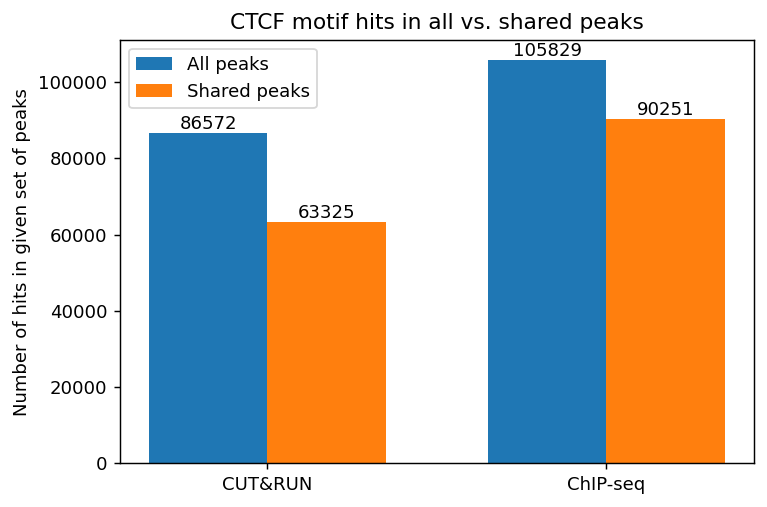

In [62]:
labels = ['CUT&RUN','ChIP-seq']
all_peaks = [len(cut_hits), len(chip_hits)]
shared_peaks = [len(shared_cut_hits), len(shared_chip_hits)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, all_peaks, width, label='All peaks')
rects2 = ax.bar(x + width/2, shared_peaks, width, label='Shared peaks')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of hits in given set of peaks')
ax.set_title('CTCF motif hits in all vs. shared peaks')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=0)
ax.bar_label(rects2, padding=0)

fig.tight_layout()

plt.show()

## b) Is there a correlation with other genomic features?


NONE OF THE COMMENTED COUNTS HAVE BEEN UPDATED SO IGNORE THEM BELOWWWW

8. Using bedtools intersect -u, intersect the motifs in the subsetted peaks with various genomic features’ BED files

In [71]:
shared_cut_hits.to_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/shared_cut_hits.tsv', sep='\t', index=False)
shared_chip_hits.to_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/shared_chip_hits.tsv', sep='\t', index=False)

### DNase-seq

In [ ]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/shared_cut_hits.tsv -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_shared_motif_hits_dnase_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/shared_chip_hits.tsv -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_shared_motif_hits_dnase_overlap')

cutnrun_shared_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_shared_motif_hits_dnase_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_shared_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_shared_motif_hits_dnase_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

### ATAC-seq

In [76]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/shared_cut_hits.tsv -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_shared_motif_hits_atac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/shared_chip_hits.tsv -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_shared_motif_hits_atac_overlap')

cutnrun_shared_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_shared_motif_hits_atac_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_shared_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_shared_motif_hits_atac_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

### acetylation

In [78]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/shared_cut_hits.tsv -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_shared_motif_hits_ac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/shared_chip_hits.tsv -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_shared_motif_hits_ac_overlap')

cutnrun_shared_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_shared_motif_hits_ac_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_shared_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_shared_motif_hits_ac_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

### trimethylation

In [77]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/shared_cut_hits.tsv -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_shared_motif_hits_me3_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/shared_chip_hits.tsv -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_shared_motif_hits_me3_overlap')

cutnrun_shared_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_shared_motif_hits_me3_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_shared_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_shared_motif_hits_me3_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

9. Also intersect the motifs in ALL peaks with various genomic features’ BED files

### DNase-seq

In [81]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/cutnrun_jan9_COUNTS_HEAD/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_all_motif_hits_dnase_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/chipseq_jan23_COUNTS_HEAD/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_all_motif_hits_dnase_overlap')

cutnrun_all_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_all_motif_hits_dnase_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_all_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_all_motif_hits_dnase_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

### ATAC-seq

In [82]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/cutnrun_jan9_COUNTS_HEAD/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_all_motif_hits_atac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/chipseq_jan23_COUNTS_HEAD/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_all_motif_hits_atac_overlap')

cutnrun_all_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_all_motif_hits_atac_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_all_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_all_motif_hits_atac_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

### acetylation

In [83]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/cutnrun_jan9_COUNTS_HEAD/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_all_motif_hits_ac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/chipseq_jan23_COUNTS_HEAD/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_all_motif_hits_ac_overlap')

cutnrun_all_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_all_motif_hits_ac_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_all_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_all_motif_hits_ac_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

### trimethylation

In [84]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/cutnrun_jan9_COUNTS_HEAD/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_all_motif_hits_me3_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/chipseq_jan23_COUNTS_HEAD/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_all_motif_hits_me3_overlap')

cutnrun_all_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/cutnrun_all_motif_hits_me3_overlap',  # 97,042 overlaps
                                sep='\t', header=None)
chipseq_all_me3_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_4/CTCF/chipseq_all_motif_hits_me3_overlap',  # 55,528 overlaps
                                sep='\t', header=None)

## PLOTTING

10. Plot the results of 8 and 9

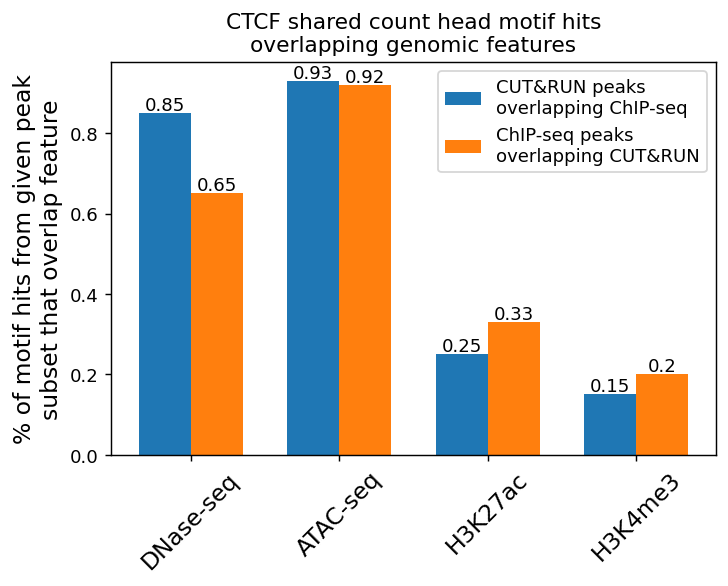

In [94]:
# order: ( % of shared CUT&RUN motif hits overlapping assay, with assay order DNASE; ATAC; ac; me, 
#          % of shared chipseq motif hits overlapping assay, with assay order DNASE; ATAC; ac; me)
cutnrun_stats = (len(cutnrun_shared_dnase_overlap) / len(shared_cut_hits),
                 len(cutnrun_shared_atac_overlap) / len(shared_cut_hits),
                 len(cutnrun_shared_ac_overlap) / len(shared_cut_hits),
                 len(cutnrun_shared_me3_overlap) / len(shared_cut_hits))
chipseq_stats = (len(chipseq_shared_dnase_overlap) / len(shared_chip_hits),
              len(chipseq_shared_atac_overlap) / len(shared_chip_hits),
              len(chipseq_shared_ac_overlap) / len(shared_chip_hits),
              len(chipseq_shared_me3_overlap) / len(shared_chip_hits))

cutnrun_stats = [round(stat, 2) for stat in cutnrun_stats]
chipseq_stats = [round(stat, 2) for stat in chipseq_stats]

ind = np.arange(len(cutnrun_stats))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=130)
rects1 = ax.bar(ind - width/2, cutnrun_stats, width, 
                label='CUT&RUN peaks\noverlapping ChIP-seq')
rects2 = ax.bar(ind + width/2, chipseq_stats, width,
                label='ChIP-seq peaks\noverlapping CUT&RUN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of motif hits from given peak\nsubset that overlap feature', fontsize=13)
ax.set_title('CTCF shared count head motif hits\noverlapping genomic features')
ax.set_xticks(ind)
ax.set_xticklabels(('DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3'), rotation=45, fontsize=13)
ax.legend(loc='upper right')

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, -0.5),  # use -0.5 point offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")

plt.show()

#### BACK TO THE BASICS MARCH 8 

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

# Import the set of peaks
peak_table = import_peak_table(['/home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF.bed'])

# Define constants
input_length, profile_length = 2114, 1000
shap_score_center_size = 400
profile_display_center_size = 400
hyp_score_key = "hyp_scores"

shap_scores_path_short, shap_scores_path_long, shap_scores_path_single = '/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/shap_scores_CTCF_120','/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/shap_scores_CTCF_150', '/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_feb7/shap_scores'


In [3]:
# THE COORDS FOR THE SHAP AND PREDS HDF5s ARE THE  * S A M E *  YES I CHECKED!


# Import SHAP coordinates and one-hot sequences
# EXACTLY SAME AS IMPORTING THE ORIGINAL HDF5 FROM PIPELINE_OUTPUTS   YES I CHECKED
# EXCEPT THIS CUTS THE CENTER TO THE 400 BP WE ARE USED TO
hyp_scores_short, _, one_hot_seqs_short, shap_coords_short = import_shap_scores(shap_scores_path_short, hyp_score_key, 
                                                              center_cut_size=shap_score_center_size, remove_non_acgt=False)
hyp_scores_long, _, one_hot_seqs_long, shap_coords_long = import_shap_scores(shap_scores_path_long, hyp_score_key, 
                                                              center_cut_size=shap_score_center_size, remove_non_acgt=False)
hyp_scores_single, _, one_hot_seqs_single, shap_coords_single = import_shap_scores(shap_scores_path_single, hyp_score_key, 
                                                              center_cut_size=shap_score_center_size, remove_non_acgt=False)
# This cuts the sequences/scores off just as how TF-MoDISco saw them, but the coordinates are uncut

# Import the set of all profiles and their coordinates
# EXACTLY SAME AS IMPORTING THE ORIGINAL HDF5 FROM PIPELINE_OUTPUTS   YES I CHECKED
true_profs_multi, pred_profs_multi, all_pred_coords_multi = import_profiles('/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/preds')
true_profs_single, pred_profs_single, all_pred_coords_single = import_profiles('/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_feb7/preds')

# each len is 4 * 54227 where 54227 is num of cut&run peaks
# if you drop_duplicates, you get exactly 54227 rows. each CORRESPONDS to the row in peak table but not in order??




Importing SHAP scores: 100%|██████████████████| 217/217 [00:03<00:00, 55.38it/s]

Importing SHAP scores: 100%|██████████████████| 109/109 [00:01<00:00, 56.62it/s]


Importing predictions:   0%|          | 0/217 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/109 [00:00<?, ?it/s]

In [5]:
all_pred_coords_single_df = pd.DataFrame(all_pred_coords_single, columns=['chrom','peak_start','peak_end'])
all_pred_coords_multi_df = pd.DataFrame(all_pred_coords_multi, columns=['chrom','peak_start','peak_end'])

In [6]:
# if you drop duplicates of all_pred_coords_single_df or short  (or the all_pred_coords_table stuff) then you can INDEX BY PEAK!!
# same for dropping duplicates of the shap_coords_short/long/single (if you convert to df first)
np.array_equal(np.array(all_pred_coords_multi_df.drop_duplicates().chrom), np.array(peak_table.loc[peak_table.chrom != 'chrM'].chrom))

True

In [67]:
def check_validity(hit, proposed_peak):
    ''' determine if a motif hit lies inside a proposed set of coords (chrom/start/end) '''
    if isinstance(proposed_peak, pd.core.frame.DataFrame) or isinstance(proposed_peak, pd.core.series.Series):
        return (hit.peak_start >= proposed_peak.peak_start) and (hit.peak_end <= proposed_peak.peak_end) and (hit.chrom == proposed_peak.chrom)
    elif isinstance(proposed_peak, np.ndarray):
        return ((hit.peak_start >= proposed_peak[1]) and (hit.peak_end <= proposed_peak[2]) and (hit.chrom == proposed_peak[0]))
    else:
        return 'what da heck is this you moron ????'


In [8]:
# find motif hits unique to long/short task, where single-task doesn't see importance
#os.system('bedtools intersect -v -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed > /home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_short_no_single')
#os.system('bedtools intersect -v -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed > /home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_long_no_single')

short_unique_hits = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_short_no_single']) # 161,418 hits
long_unique_hits = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_long_no_single'])   # 155,922 hits

# so about half of the hits for both short and long tasks are unique to them and don't overlap single-task hits
# but it is NOT true that every single-task hit overlaps a short/long hit, if you compare the numbers of motif hits 


In [11]:
# subset to TA motif hits
TA_hits_max = hits_max.loc[hits_max.name == '0_1']  # len 160,414
TA_hits_min = hits_min.loc[hits_min.name == '0_1']  # len 179,126
TA_hits_single = hits_single.loc[hits_single.name == '0_1']  # len 40,332

TA_hits_max_no_single = short_unique_hits.loc[short_unique_hits.name == '0_1']  # len 114,501
TA_hits_min_no_single = long_unique_hits.loc[long_unique_hits.name == '0_1']  # len 128,450

#### Notes: 
* true_profs, pred_profs, all_pred_coords: each len is 2 * or 4 * 54227 where 54227 is num of cut&run peaks
    * if you drop_duplicates, you get exactly 54227 rows. each CORRESPONDS to the row in peak table but is an EXTENDED TO 2114 VERSION of peak
* ^^ same with shap_coords_table
* subset_inds reorders original profs/coords i think

In [14]:
# find the peak indices where TA motif is found in BOTH min and max and NOT IN SINGLE
peak_indices_minmax = set(TA_hits_min.strand.unique()).intersection(set(TA_hits_max.strand.unique()))
peak_indices_not_in_single = peak_indices_minmax - set(TA_hits_single.strand.unique())